- Imported libraries 
- Imported dataset 
- Created svm classifier

In [127]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

- Used KDTree for finding the closest point
- Rewrote the optimal_point function around KDTree

In [103]:
from scipy.spatial import KDTree

# Function to reflect a point across the contour
def closest_point(point, contour, margin=0.0001):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    return closest_point + (margin)*(closest_point - point)

def reflect_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    reflected_point = closest_point + (closest_point - point)
    return reflected_point

In [185]:
from scipy.interpolate import interp1d

def direction_func(data_pt, vector, scaler, margin): 
    modified_pt = data_pt + vector*scaler - margin
    return modified_pt

def flip_matrix(matrix):
    return matrix[::-1]

# Generates the decision boundary in the case of binary classification
def boundary_generator(xx1, xx2, model): 
    x_in = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx1.shape)
    bound_data = []
    contour = plt.contour(xx1, xx2, y_pred, colors='red')
    for collection in contour.collections[:1]:
        for path in collection.get_paths():
            vertices = path.vertices
            x_coords = vertices[:, 0]
            y_coords = vertices[:, 1]
            bound_data.extend(zip(x_coords,y_coords))
    boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
    return boundary_df

# Gets boundary points
def boundary_points(xx1, xx2, model): 
    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]
    return bound_x, bound_y 

# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(df, model, desired_class, undesired_coords): 

    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values

    model.fit(X_train, y_train)

    bound_x, bound_y = None, None
    X = X_train
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    bound_x, bound_y = boundary_points(xx1, xx2, model)

    N = 200000
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
    Y_pred = f(X_pred)

    contours = np.c_[X_pred, Y_pred]
    plt.plot(X_pred, Y_pred, color='black')

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    if desired_class == 1: 
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        min_dist_vec = optimal_datapt - undesired_datapt 
        reduction = 0.2 
        final_datapt = direction_func(undesired_datapt, min_dist_vec, reduction, margin=0.0001)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(final_datapt[0], final_datapt[1], c = 'r')
        plt.text(final_datapt[0]+0.002, final_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], final_datapt[0]], [undesired_datapt[1],final_datapt[1]], linestyle='--')
        return final_datapt

array([10.72943208, 10.47219328])

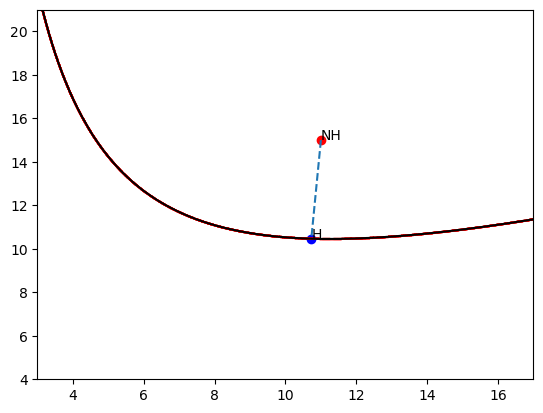

In [186]:
optimal_projection1 = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15))
optimal_projection1

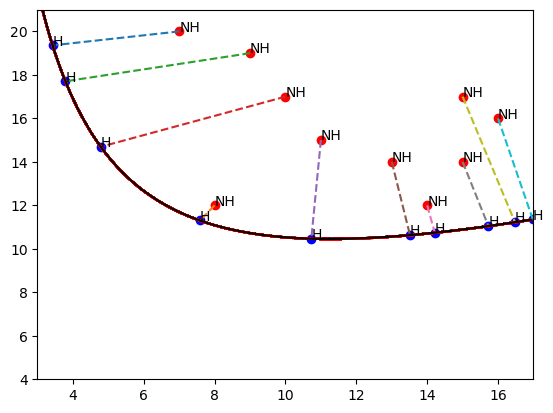

In [187]:
# Data frame consisting of all "non-healthy" data points or points where the classification is -1
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])

optimal_datapts1 = pd.DataFrame(data=[], columns=('x1', 'x2'))

# Iterates over each of the rows of the undesired dataframe and finds the optimal point
for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]))
    optimal_datapts1.loc[len(optimal_datapts1)] = optimal_pt

In [188]:
optimal_datapts1

,x1,x2
0,3.426753,19.359191
1,7.587217,11.305104
2,3.789514,17.705980
3,4.787295,14.694304
4,10.729432,10.472193
5,13.514262,10.633843
6,14.214508,10.744598
7,15.727032,11.050517
8,16.476517,11.228849
9,16.980833,11.356546


- The black line was generated from a set of points where the probability from the classifier matched 0.5 exactly or was sufficiently close to 0.5 (50%) 
- The red line was generated using the boundary function that we have defined above

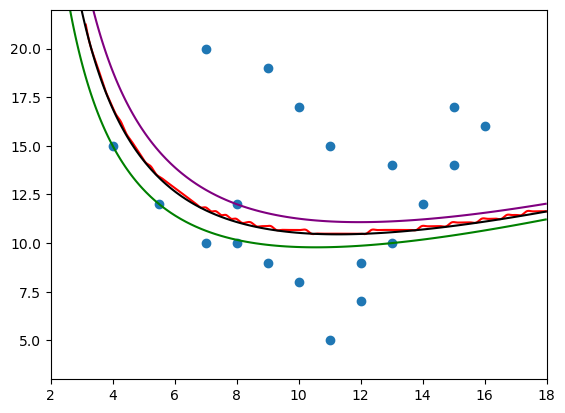

In [195]:
X1=df['x1']
X2=df['x2']
X_train=np.array(list(zip(X1,X2)))
y_train=df['y'].values
X=X_train

svm_classifier.fit(X_train, y_train)

X = X_train
x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 100),np.linspace(x2_min, x2_max, 100))
Z = svm_classifier.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
x_in = np.c_[xx1.ravel(), xx2.ravel()]
y_pred = svm_classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx1.shape)

bound_data = []
contour = plt.contour(xx1, xx2, y_pred, colors='black')
for collection in contour.collections[:1]:
    for path in collection.get_paths():
        vertices = path.vertices
        x_coords = vertices[:, 0]
        y_coords = vertices[:, 1]
        bound_data.extend(zip(x_coords,y_coords))
for collection in contour.collections:
    collection.set_visible(False)
boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
N=200000
boundary_df = boundary_df.drop_duplicates(subset='x1')
bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

f = interp1d(bound_x, bound_y, kind='cubic')
X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
Y_pred = f(X_pred)
plt.plot(X_pred, Y_pred, c='r')
plt.contour(xx1, xx2, Z, levels=[-1, 0, 1], colors=['purple','black','green'])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

array([10.94578642, 14.09433866])

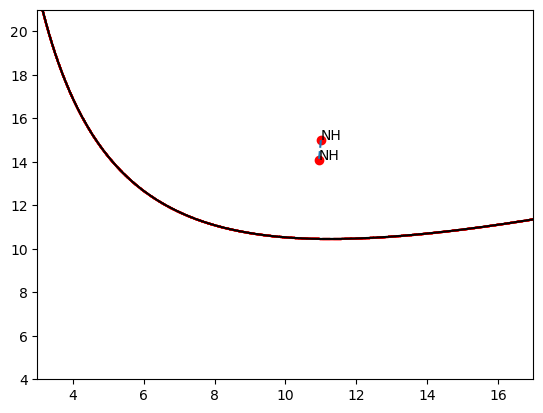

In [190]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15))
optimal_projection

array([ 6.293309  , 19.83855988])

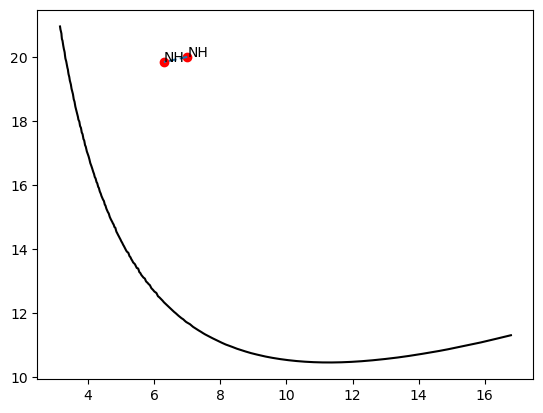

In [111]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(7,20))
optimal_projection